<h1 style="font-weight: bold; text-transform: uppercase; font-family: 'Times New Roman'">cnn train</h1>

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">libraries</h2>

In [4]:
import os
import time
import requests
import random
import numpy as np
from PIL import Image, ImageEnhance
from scipy.ndimage import convolve
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from dotenv import load_dotenv

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">config</h2>

In [5]:
IMG_SIZE = (128, 128)
MODEL_PATH = "models/best_cnn_stego.keras"
TOTAL_IMAGES = 200
BATCH_SIZE = 30
QUERY = "landscape"

load_dotenv()
UNSPLASH_ACCESS_KEY = os.getenv("ACCESS_KEY")
if not UNSPLASH_ACCESS_KEY:
    raise ValueError("Missing Unsplash API key.")

os.makedirs("data/cover", exist_ok=True)
os.makedirs("data/stego", exist_ok=True)
os.makedirs("models", exist_ok=True)

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">download image from unslash</h2>

In [1]:
def download_unsplash_images_batch(query=QUERY, total_count=TOTAL_IMAGES, batch_size=BATCH_SIZE):
    downloaded = 0
    while downloaded < total_count:
        count = min(batch_size, total_count - downloaded)
        url = f"https://api.unsplash.com/photos/random?query={query}&count={count}&client_id={UNSPLASH_ACCESS_KEY}"
        response = requests.get(url)
        data = response.json()
        for i, item in enumerate(data):
            img_url = item["urls"]["small"]
            img_data = requests.get(img_url).content
            with open(f"data/cover/{query}_{downloaded + i}.jpg", "wb") as f:
                f.write(img_data)
        downloaded += count
        print(f"Downloaded {downloaded}/{total_count} images")
        time.sleep(1)

download_unsplash_images_batch()

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">lsb embed</h2>

In [6]:
def embed_message(image: Image.Image, message: str):
    arr = np.array(image).astype(np.uint8)
    flat = arr.flatten().astype(np.uint8)
    binary_msg = ''.join(format(ord(c), '08b') for c in message) + "1111111111111110"
    if len(binary_msg) > len(flat):
        raise ValueError("Message too long")
    for i, bit in enumerate(binary_msg):
        flat[i] = (flat[i] & 0b11111110) | int(bit)
    arr2 = flat.reshape(arr.shape)
    return Image.fromarray(arr2)

long_message = "Lorem Ipsum is dummy text. Confidential message."
for fname in os.listdir("data/cover"):
    cover_path = os.path.join("data/cover", fname)
    image = Image.open(cover_path).convert("RGB").resize(IMG_SIZE)
    stego_img = embed_message(image, long_message)
    stego_img.save(f"data/stego/stego_{fname}")

print("✅ Generated stego images")

✅ Generated stego images


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">high pass residuals</h2>

In [22]:
def high_pass_residual(img_array):
    kernel = np.array([[0, -1, 0],
                       [-1, 4, -1],
                       [0, -1, 0]])
    res = np.stack([convolve(img_array[:,:,c], kernel, mode='reflect') for c in range(3)], axis=2)
    # Keep range as is (-inf,+inf), clip extreme values
    res = np.clip(res, -1.0, 1.0)
    return res


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">augmentation</h2>

In [16]:
def augment_image(img):
    # Random horizontal flip
    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    # Random brightness
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(0.8 + 0.4*random.random())
    # Random contrast
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(0.8 + 0.4*random.random())
    # Small rotation ±5 degrees
    if random.random() > 0.5:
        angle = random.uniform(-5,5)
        img = img.rotate(angle)
    return img

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">load dataset</h2>

In [24]:
def load_images(folder, label, augment=False):
    imgs, labels = [], []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        try:
            img = Image.open(path).convert("RGB").resize(IMG_SIZE)
            if augment:
                img = augment_image(img)
            arr = np.array(img)/255.0
            arr = high_pass_residual(arr)
            imgs.append(arr)
            labels.append(label)
        except:
            continue
    return imgs, labels

cover_imgs, cover_labels = load_images("data/cover", 0, augment=True)
stego_imgs, stego_labels = load_images("data/stego", 1, augment=True)

X = np.array(cover_imgs + stego_imgs)
y = np.array(cover_labels + stego_labels)
print("Dataset shape:", X.shape, y.shape)

Dataset shape: (400, 128, 128, 3) (400,)


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">split data</h2>

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">build cnn model</h2>

In [26]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='tanh', padding='same', input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


d:\UIT\1.steganography\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,961 (613.13 KB)

 Trainable params: 156,513 (611.38 KB)

 Non-trainable params: 448 (1.75 KB)

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">callbacks</h2>

In [27]:
checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max")
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">train</h2>

In [28]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.6969 - loss: 0.5610 - val_accuracy: 0.7625 - val_loss: 0.6298
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - accuracy: 0.8594 - loss: 0.3246 - val_accuracy: 0.5000 - val_loss: 0.7582
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.8781 - loss: 0.2463 - val_accuracy: 0.5250 - val_loss: 0.7023
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 318ms/step - accuracy: 0.9625 - loss: 0.1245 - val_accuracy: 0.5375 - val_loss: 0.7925
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.9500 - loss: 0.1259 - val_accuracy: 0.5000 - val_loss: 1.1571
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.8844 - loss: 0.2735 - val_accuracy: 0.7250 - val_loss: 0.7694


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">training plot</h2>

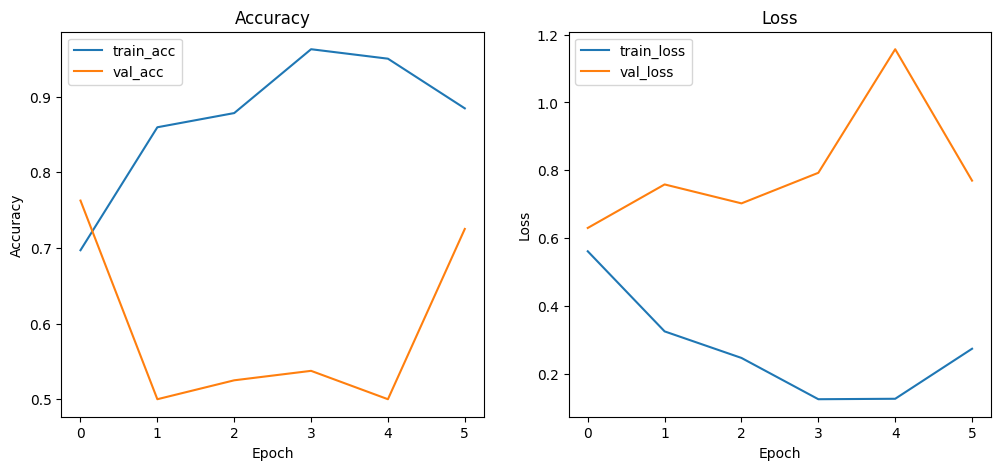

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">evaluation</h2>

In [30]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"✅ Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.7625 - loss: 0.6298
✅ Validation Accuracy: 0.7625, Loss: 0.6298


<h2 style="font-weight: bold; text-transform: capitalize; font-family: 'Times New Roman'">test set evaluation</h2>

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9803921568627452..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4392156862745098..0.5686274509803922].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8235294117647058..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping 

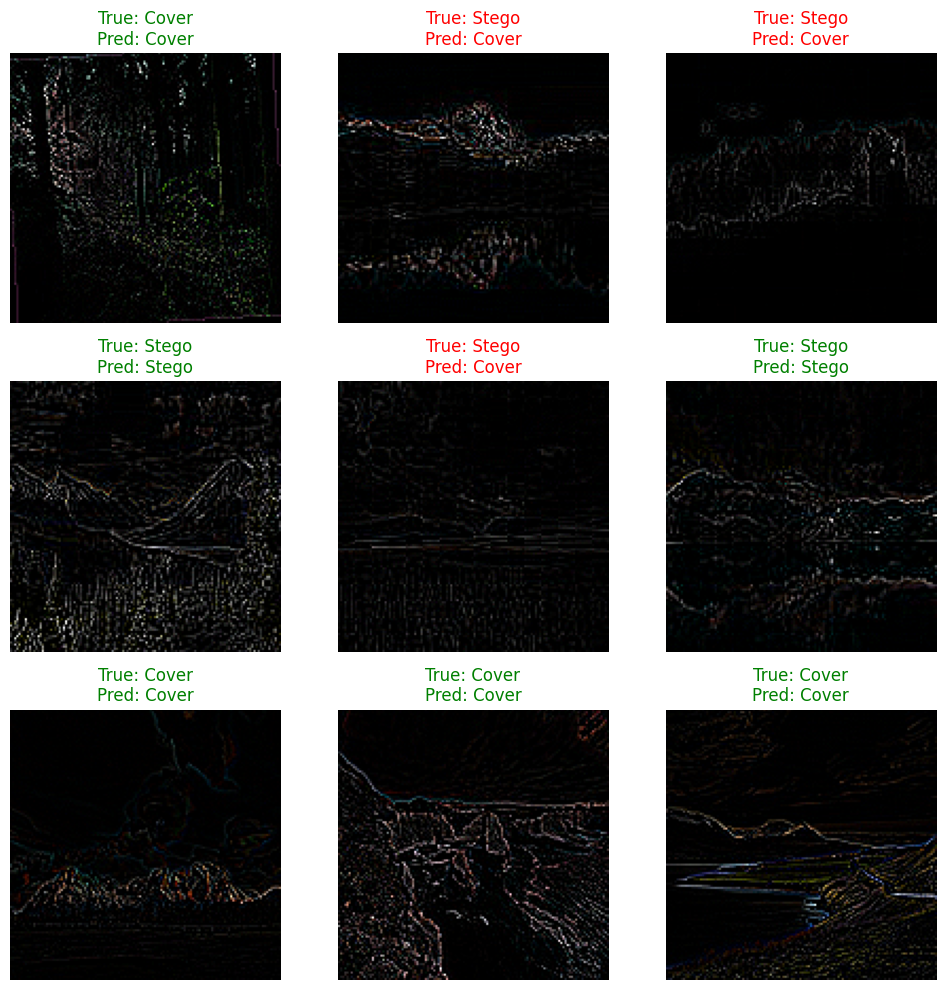

In [31]:
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

num_samples = 9
indices = random.sample(range(len(X_val)), num_samples)

plt.figure(figsize=(10,10))
for i, idx in enumerate(indices):
    plt.subplot(3,3,i+1)
    img = X_val[idx]
    plt.imshow(img)
    plt.axis('off')
    true_label = "Cover" if y_val[idx]==0 else "Stego"
    pred_label = "Cover" if y_pred[idx]==0 else "Stego"
    color = "green" if y_val[idx]==y_pred[idx] else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
plt.tight_layout()
plt.show()